# Tree Height Parameter Estimation

In [3]:
import sys,os
from numpy.core.defchararray import asarray
import pandas as pnd
import geopandas as gpd
from shapely import geometry
import rasterio
import rasterio.mask
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from ImageProcessor import RasterOperators, VectorOperators
from shapely.geometry import Point, Polygon ,LineString, mapping
from rasterio.warp import reproject
from rasterio.control import GroundControlPoint
from fiona.crs import from_epsg
import pandas as pnd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
from Others import HeightEstimationUtils as heu
import gdal
import random
from random import randrange, uniform
from fiona.crs import from_epsg
from ProjectConstants import GlobalConstants as gc
import statsmodels.api as sm
from rasterio.plot import show
from matplotlib import pyplot
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# Read the Reference and the Data shape files

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


   gen_id  BlockNum     genotype_i
0    2322        10  SCA-10-2322-1
1    2322        10  SCA-10-2322-2
2    2322        10  SCA-10-2322-3
3    2322        10  SCA-10-2322-4
4    2322        10  SCA-10-2322-5
0.0 1.0


Text(0.5,1,'Reference Trees')

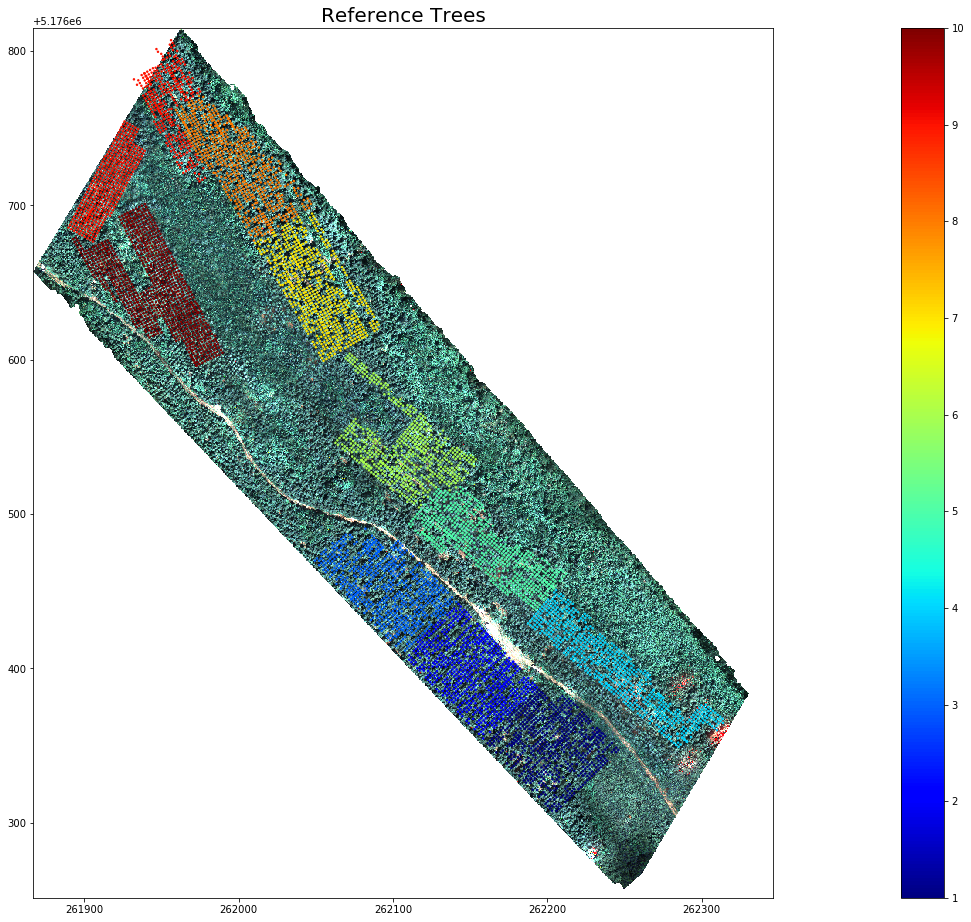

In [4]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# -- Read the reference data ###
D100TreeRefData = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/Site_info/ReferenceData/StCas_TREE_RS_DATA.shp'
treetopsshp = gpd.read_file(D100TreeRefData)
treetopsshp.rename(columns={"tree_id":"genotype_i"},inplace=True)
print(treetopsshp[['gen_id','BlockNum','genotype_i']].head())

# %matplotlib inline
fig, (ax1) = pyplot.subplots(1,1,figsize=(46, 16))
raster = rasterio.open('/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/OrthoPhoto/20170626_Ortho_Photo_resampled.tif')
image = normalize(raster.read([3,2,1]))
image[image==0] = np.max(image)
image[image==np.min(image)] = 0
print(np.min(image),np.max(image))
show(image*20.0, transform=raster.transform,ax=ax1, vmin=0, vmax=1, aspect='auto')
treetopsshp.plot(ax=ax1,column='BlockNum', cmap='jet', markersize=2, legend=True)
ax1.set_title('Reference Trees', fontsize=20)


# Localize Tree Tops and Get Tree Height from nDSM

Text(0.5,1,'Canopy Height Model(Estiamted Tree tops)')

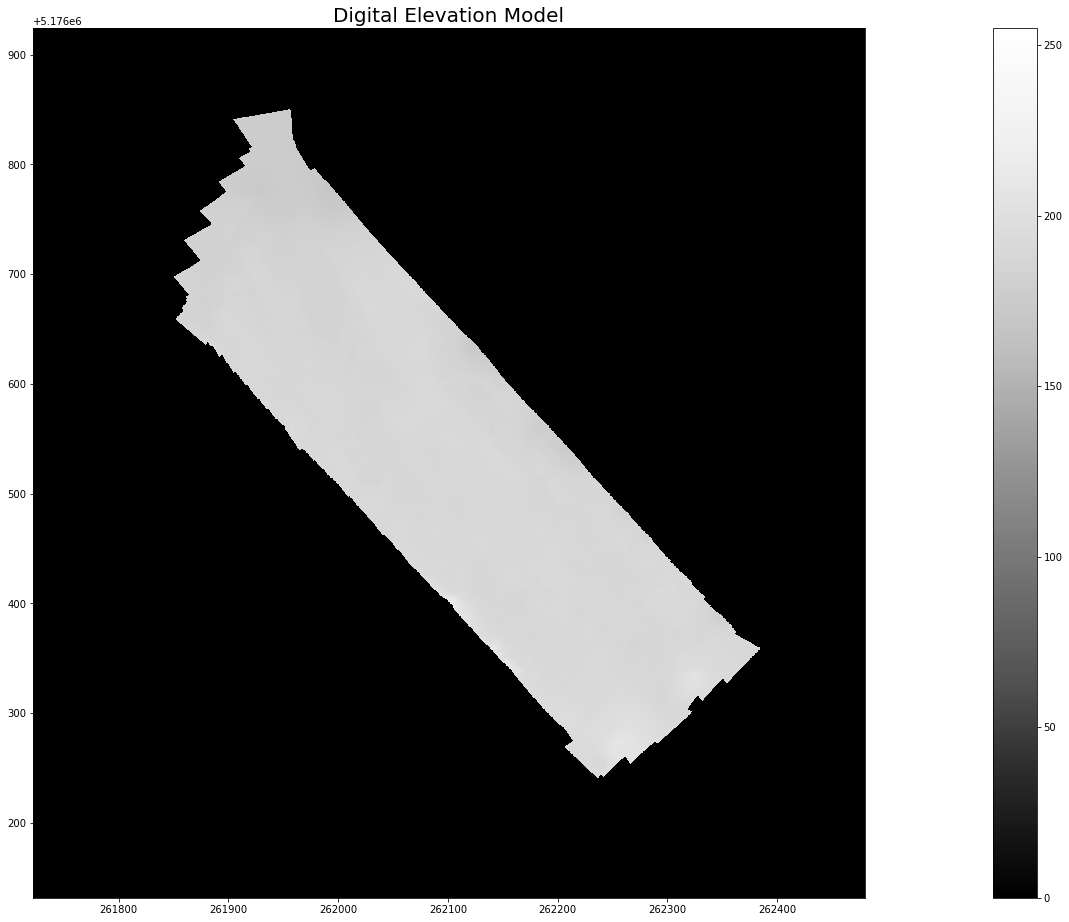

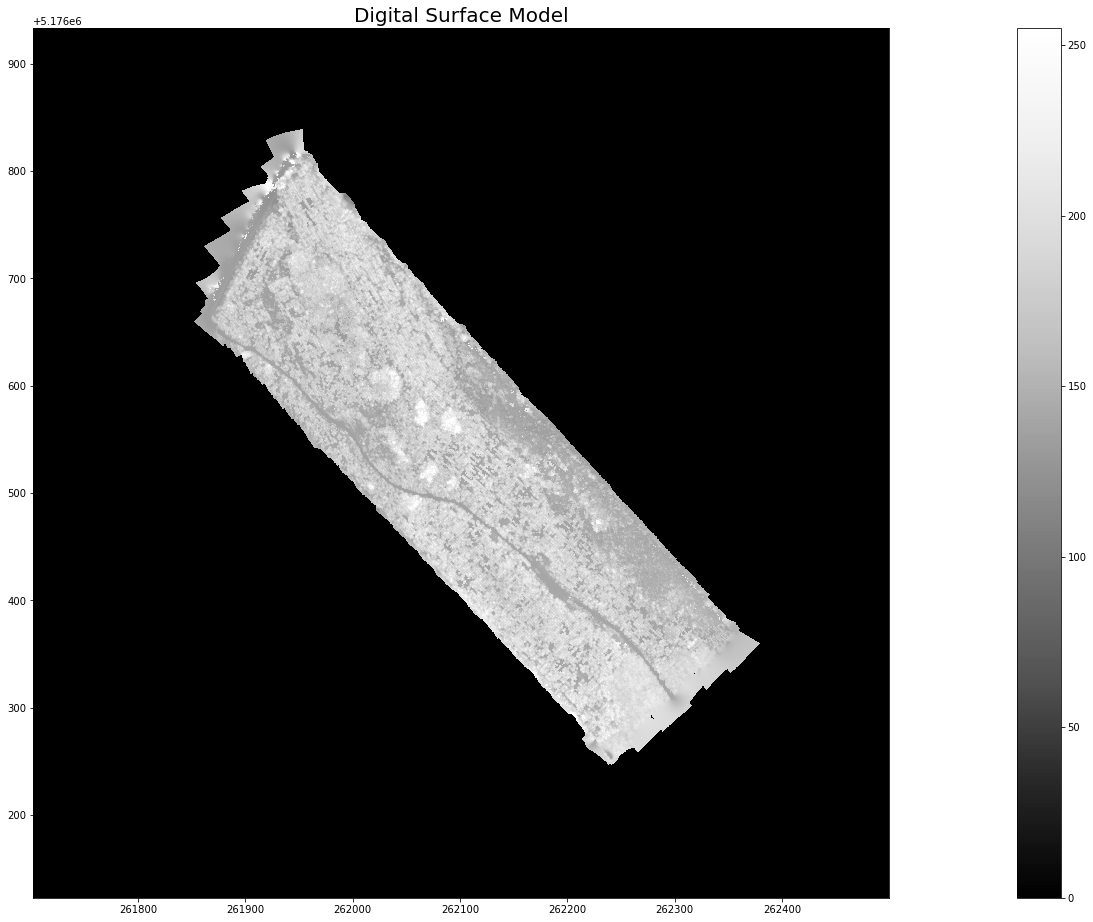

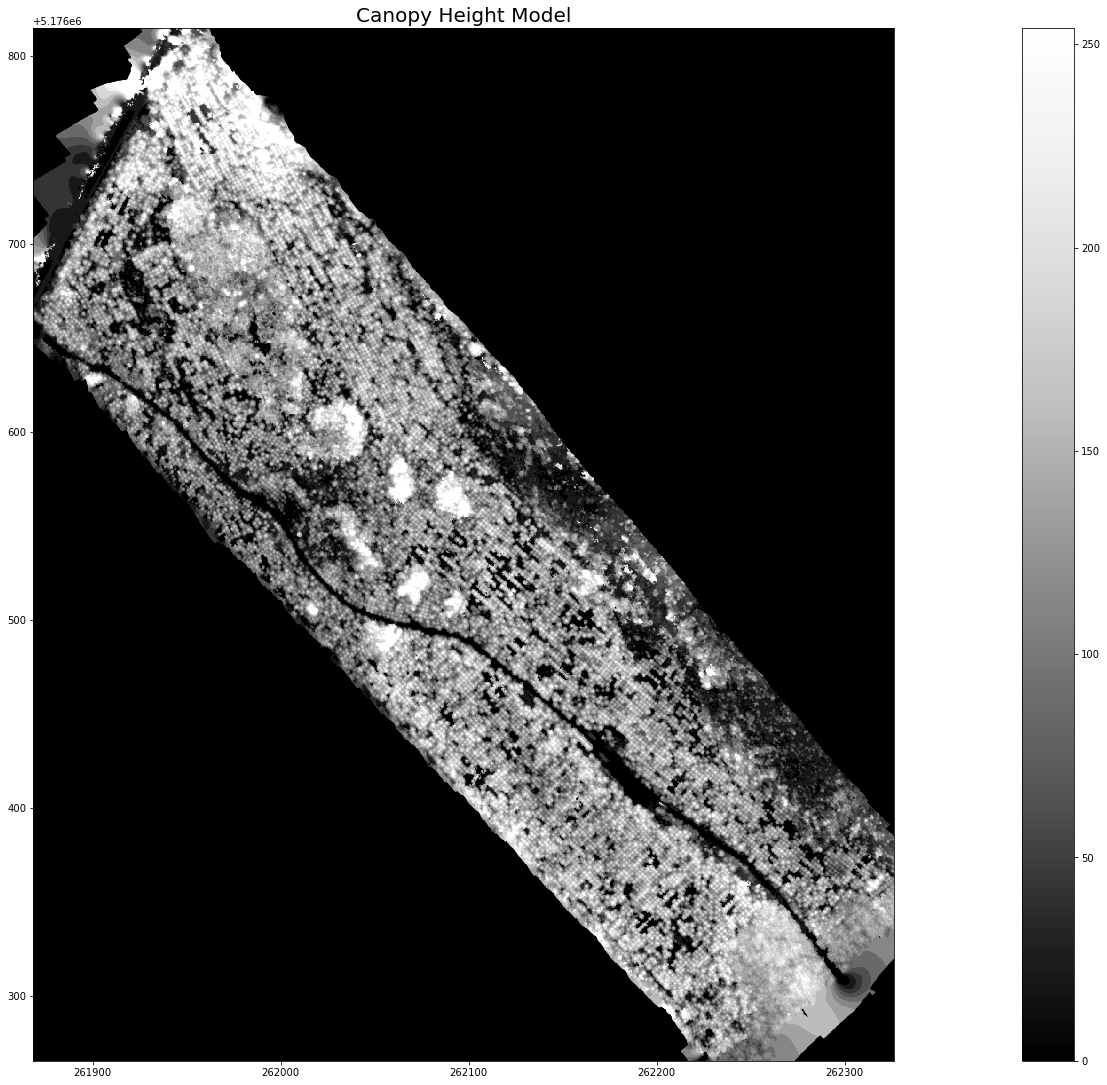

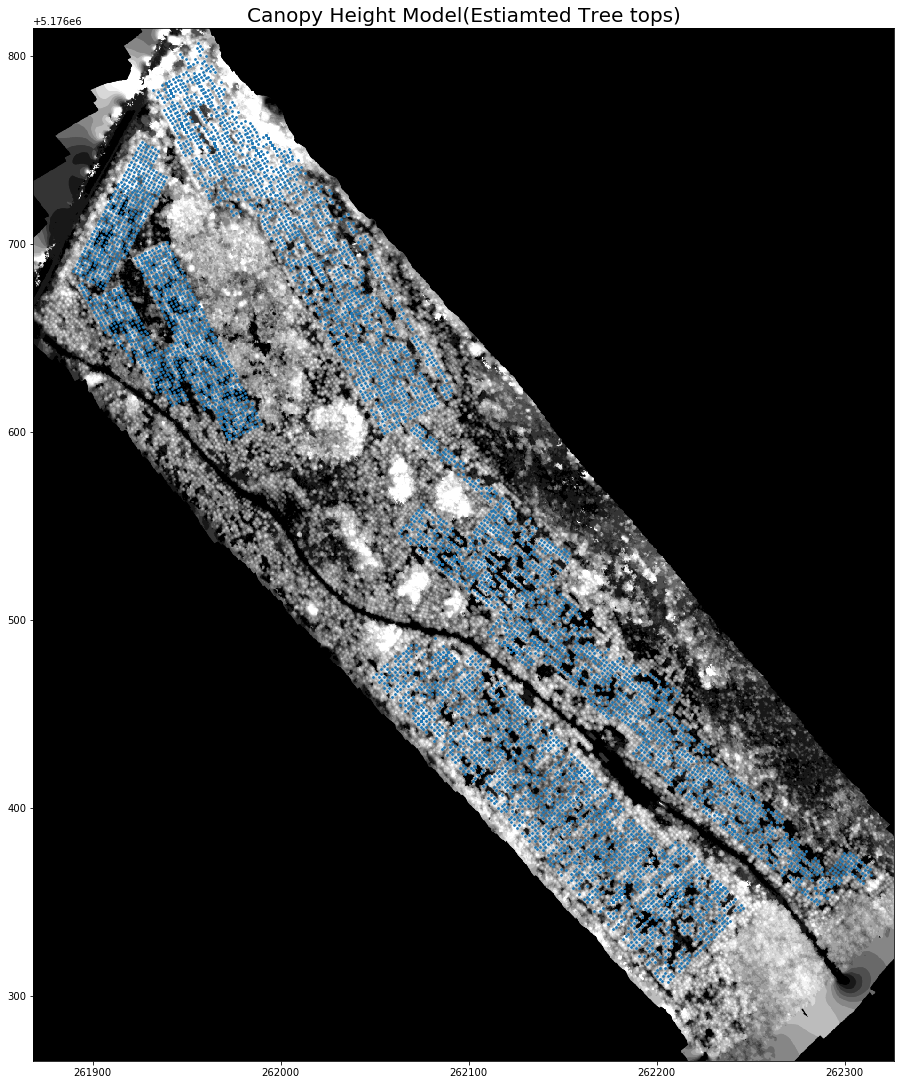

In [5]:
# -- Read DSM file from 20180626 ### 
DEM_Path = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/DEM_rs.tif'
DSM_Path = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/DSM_rs.tif'
nDSM_Path = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/nDSM/nDSM-Original/20170626_nDSM_Image_rs.tif'
# -- Read the tree top file from 20180626

fig, (ax1) = pyplot.subplots(1,1,figsize=(46, 16))
src = rasterio.open(DEM_Path)

# use imshow so that we have something to map the colorbar to
dem_hidden = ax1.imshow(normalize(src.read(1))*255, cmap='Greys_r')
z1_plot = show((src,1), transform=src.transform, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0, vmax=73, ax=ax1,aspect='equal')
ax1.set_title('Digital Elevation Model', fontsize=20)
# plt.colorbar(z1_plot,cax=ax1)
fig.colorbar(dem_hidden, ax=ax1)

fig, (ax2) = pyplot.subplots(1,1,figsize=(46, 16))
src2 = rasterio.open(DSM_Path)
dsm_hidden1 = ax2.imshow(normalize(src2.read(1))*255, cmap='Greys_r')
show((src2,1), transform=src.transform, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=40, vmax=73, ax=ax2,aspect='equal')
ax2.set_title('Digital Surface Model', fontsize=20)
fig.colorbar(dsm_hidden1, ax=ax2)

fig, (ax3) = pyplot.subplots(1,1,figsize=(46, 19))
src3 = rasterio.open(nDSM_Path)
ndsm_hidden1 = ax3.imshow(src3.read(1), cmap='Greys_r')
show((src3,1), transform=src.transform, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0, vmax=103, ax=ax3,aspect='equal')
ax3.set_title('Canopy Height Model', fontsize=20)
fig.colorbar(ndsm_hidden1, ax=ax3)

fig, (ax4) = pyplot.subplots(1,1,figsize=(46, 19))
src4 = rasterio.open(nDSM_Path)
show((src4,1), transform=src.transform, cmap=plt.get_cmap('gray'), interpolation='nearest', vmin=0, vmax=103, ax=ax4,aspect='equal')
# D1_shp_path.plot(ax=ax,column='BlockNum', cmap=None, markersize=10, legend=True)
treetopsshp.plot(ax=ax4, markersize=3, legend=False)
ax4.set_title('Canopy Height Model(Estiamted Tree tops)', fontsize=20)
# fig.colorbar(ndsm_hidden2, ax=ax4)


In [17]:
# -- Read DSM file from 20180626 ### 
# D1_nDSM_Path = '/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/nDSM/nDSM.tif'
# -- Read the tree top file from 20180626
# D1_shp_path = gpd.read_file('/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/UAV/StCasimir/2018/ProcessedMSData/20170626/ITC-Data/All-ITC/shapefile_merged.shp')
HT_DATA_20170626 = gpd.read_file("/home/ensmingerlabgpu/Desktop/2018/ProcessedMSData/20170626/ITC-Data/All-ITC/ITCSpectralInfowithTreeHt.shp")
HT_DATA_REF = gpd.read_file('/mnt/4TBHDD/Spruce_Up_New_Copy/SpruceUp/Site_info/ReferenceData/SC_TREE_REFERENCE_DATA_1.shp')
# Get Proximal Trees
final_gdf_treetop = heu.GetProximalPoints(HT_DATA_REF, HT_DATA_20170626,5)

# final_gdf_treetop.r['A18_04_Hau']
final_gdf_treetop.dropna(subset=['A18_04_Hau'], inplace=True)
final_gdf_treetop.rename(columns={'A18_04_Hau':'RefHeight','TreeHeight':'nDSMValHeightD1'}, inplace=True)
final_gdf_treetop["RefHeight"] = final_gdf_treetop["RefHeight"]/100


HT_DATA_20180516 = gpd.read_file("/home/ensmingerlabgpu/Desktop/2018/ProcessedMSData/20180516/ITC-Data/ITCSpectralInfowithTreeHt.shp")
final_gdf_treetop1 = heu.GetProximalPoints(HT_DATA_REF, HT_DATA_20180516,5)
final_gdf_treetop1.dropna(subset=['A18_04_Hau'], inplace=True)
final_gdf_treetop1.rename(columns={'A18_04_Hau':'RefHeight','TreeHeight':'nDSMValHeightD2'}, inplace=True)
final_gdf_treetop['nDSMValHeightD2'] = final_gdf_treetop1['nDSMValHeightD2']

# # Merge rows in the reference and real datasets based on genotype_id
# final_gdf_treetop = final_gdf_treetop.merge(testdf, how='inner', on='IDC')
print(final_gdf_treetop[['no_bloc','genotype_i','nDSMValHeightD1','nDSMValHeightD2','RefHeight']].head())
print(final_gdf_treetop['no_bloc'].count())




     no_bloc    genotype_i  nDSMValHeightD1  nDSMValHeightD2  RefHeight
974        1  SCA-1-2093-1            88.56            96.60        8.3
975        1  SCA-1-2093-2            75.68            83.72        7.9
976        1  SCA-1-2356-1           106.60           115.00       11.5
977        1  SCA-1-2356-2            86.84            94.28        9.4
978        1  SCA-1-2356-3            87.84           102.00       10.1
5020


# Get Tree Height Estimate from nDSM's Digital Number

In [18]:
def getEstimatedHeightD1(df_in):
#     df_in.dropna(inplace=True)
    X = df_in["nDSMValHeightD1"]
    y = df_in["RefHeight"]
    # Note the difference in argument order
    listvals = list(zip(X,y))
#     print(len(df_in))
    randlist= random.sample(listvals, k=200)
    tmpFile = gpd.GeoDataFrame(columns=['X','Y'])
    for a, b in randlist:
        tmpFile = tmpFile.append({'X': a, 'Y': b}, ignore_index=True)
    model = sm.OLS(tmpFile['Y'], tmpFile['X'],M=sm.robust.norms.HuberT()).fit()
    print(model.summary())
    return model

def getEstimatedHeightD2(df_in):
#     df_in.dropna(inplace=True)
    X = df_in["nDSMValHeightD2"]
    y = df_in["RefHeight"]
    # Note the difference in argument order
    listvals = list(zip(X,y))
#     print(len(df_in))
    randlist= random.sample(listvals, k=200)
    tmpFile = gpd.GeoDataFrame(columns=['X','Y'])
    for a, b in randlist:
        tmpFile = tmpFile.append({'X': a, 'Y': b}, ignore_index=True)
    model = sm.OLS(tmpFile['Y'], tmpFile['X'],M=sm.robust.norms.HuberT()).fit()
    print(model.summary())
    return model

In [19]:
# Get height estimate from DSM DN value
# Remove outliers
q_low = final_gdf_treetop["RefHeight"].quantile(0.01)
q_hi  = final_gdf_treetop["RefHeight"].quantile(0.99)
final_gdf_treetop = final_gdf_treetop[(final_gdf_treetop["RefHeight"] < q_hi) & (final_gdf_treetop["RefHeight"] > q_low)]

# Model relationship
print(final_gdf_treetop['no_bloc'].count())
modelD1 = getEstimatedHeightD1(final_gdf_treetop)
height_estimates_from_d1 = modelD1.predict(final_gdf_treetop['nDSMValHeightD1'])

modelD2 = getEstimatedHeightD2(final_gdf_treetop)
height_estimates_from_d2 = modelD2.predict(final_gdf_treetop['nDSMValHeightD2'])

# 
# add estimated height as the last column in the Dataframe
final_gdf_treetop['HeightEstD1'] = height_estimates_from_d1
final_gdf_treetop['HeightEstD2'] = height_estimates_from_d2
final_gdf_treetop['D1miusD2'] = final_gdf_treetop['HeightEstD1']-final_gdf_treetop['HeightEstD2']
final_gdf_treetop["TreeHeightInMeters"] = final_gdf_treetop["RefHeight"] # convert to meters

final_gdf_treetop["Forest_ID"] = [i*0+1 for i in range(final_gdf_treetop["no_bloc"].count())]
print(final_gdf_treetop[['no_bloc','genotype_i','TreeHeightInMeters','HeightEstD1','HeightEstD2','D1miusD2']].head())

# outshpfile = '/home/ensmingerlabgpu/Desktop/2018/ProcessedMSData/gendata.shp'
# final_gdf_treetop.to_file(driver= 'ESRI Shapefile', filename = outshpfile)

4899
                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                              4739.
Date:                Thu, 28 Oct 2021   Prob (F-statistic):                   9.67e-141
Time:                        07:31:41   Log-Likelihood:                         -413.46
No. Observations:                 200   AIC:                                      828.9
Df Residuals:                     199   BIC:                                      832.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

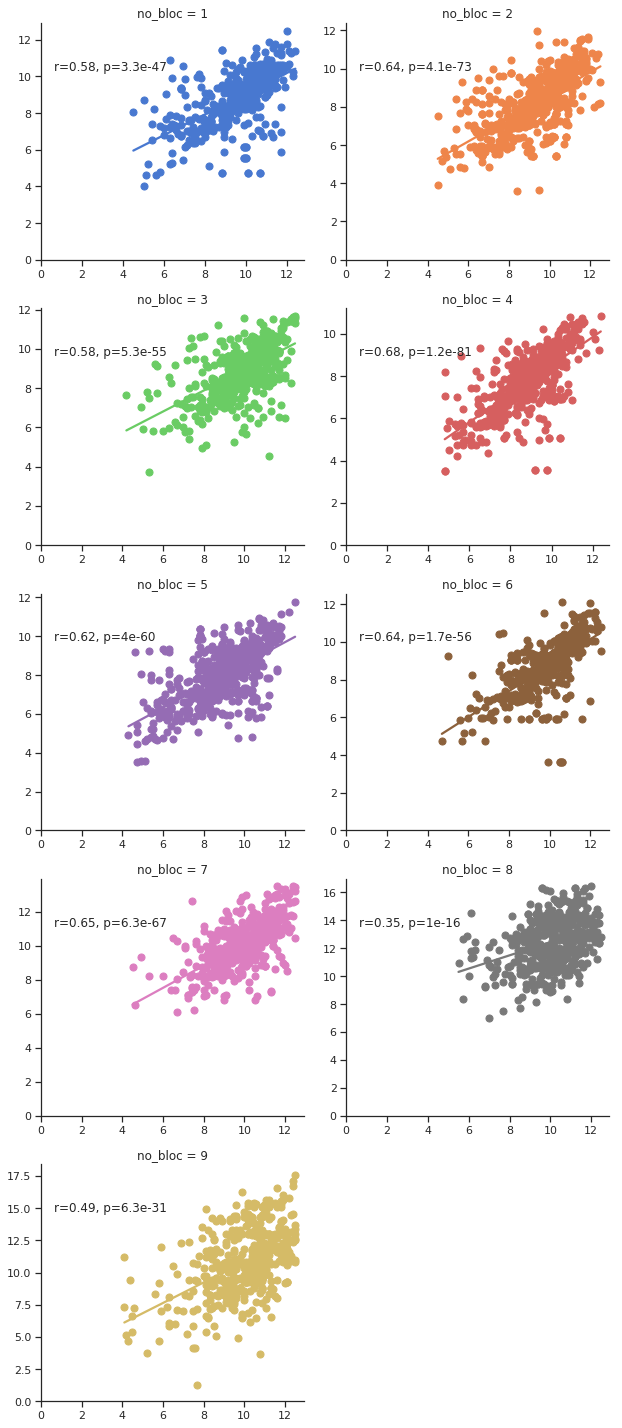

In [20]:
sns.set(style="ticks")
df = final_gdf_treetop[['no_bloc','TreeHeightInMeters','HeightEstD1','HeightEstD2','D1miusD2','Forest_ID']]

# Show the results of a linear regression within each dataset
g = sns.lmplot(x="TreeHeightInMeters", y="HeightEstD2", col="no_bloc", hue="no_bloc", data=df,
           col_wrap=2, ci=None, palette="muted", height=4, aspect=1.1, fit_reg=True, sharex=False,sharey=False,
           scatter_kws={"s": 50, "alpha": 1})
g.set(ylim=(0, None))
g.set(xlim=(0, None))
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['TreeHeightInMeters'], data['HeightEstD2'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
#     ax.set_ylim(0,)
#     ax[0,1].set_ylim(0,)
    
g.map_dataframe(annotate)